# Ensemble Learning: Bagging

In this notebook and the following two, we will explore some of the most common ensemble learning strategies. The key idea in ensemble learning is to combine the power of multiple ML models to solve a task. It has been observed that ensemble methods usually improve the overall performance of a model. This notebook is adapted from [[1](#References)].

In any machine learning model, the generalization error is given by 

> generalization error = bias + variance + irreducible error

Irreducible errors are something that is beyond us! We cannot reduce them. However, using ensemble techniques, we can reduce the bias and variance of a model to an extent, as well as improve the prediction accuracy of the final model. This reduces the overall generalization error.   

1. Bias is an error that arises due to incorrect assumptions in the learning algorithm, which is the backbone of any machine learning model. A high bias can cause a machine-learning algorithm to skip relevant information and miss important correlations between the independent variables and the class labels, thereby underfitting the model.

2. The variance in a model means how sensitive the model is to small fluctuations in training data. That is by how much the model changes with small changes in the training samples. High variance in a machine learning algorithm will make the model prone to random noise present in the dataset, thereby overfitting the model.  

We use this approach regularly in our daily lives as well -  for example, we ask for the opinions of several different experts before arriving at a conclusion, we generally consult several doctors before agreeing to a particular medical procedure, we read so many reviews written by different customers before setting our mind to buy a particular product. In each of the above scenarios, we are trying to minimize the likelihood of an unfortunate decision made by one person (in our case, a poor model).  

Typically, ensemble learning can be categorized into four categories:

1. Bagging: Bagging is mostly used to reduce the variance in a model. A simple example of bagging is the Random Forest algorithm.

2. Boosting: Boosting is mostly used to reduce the bias in a model. Examples of boosting algorithms are Ada-Boost, XGBoost, Gradient Boosted Decision Trees, etc.

3. Stacking: Stacking is mostly used to increase the prediction accuracy of a model. For implementing stacking, we will use the mlextend library provided by sci-kit learn.

4. Cascading: This class of models is very accurate. Cascading is mostly used in scenarios where you cannot afford a mistake. For example, a cascading technique is mostly used to detect fraudulent credit card transactions, or maybe when you want to be absolutely sure that you don't have cancer. 

This notebook and the following two will discuss the ensemble learning strategies called Bagging, Boosting, and Stacking with some code samples. 


## Dataset

For simplicity, we will be using the Iris dataset. Iris dataset contains information about three species of flowers - setosa, versiclor, and virginica. The four features that distinguish these flowers are petal length, septal length, petal width, and sepal width. The main aim of a classification model is to learn the relationships between the features and the class label and thereby classifying the three species of flowers.



In [1]:
%matplotlib inline
import sqlite3, pandas as pd, numpy as np, nltk, string, matplotlib.pyplot as plt, seaborn as sns
import string, math, pickle
import warnings

warnings.filterwarnings("ignore")

from xgboost.sklearn import XGBModel, XGBRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import datasets

## Load Iris dataset + pair plots.

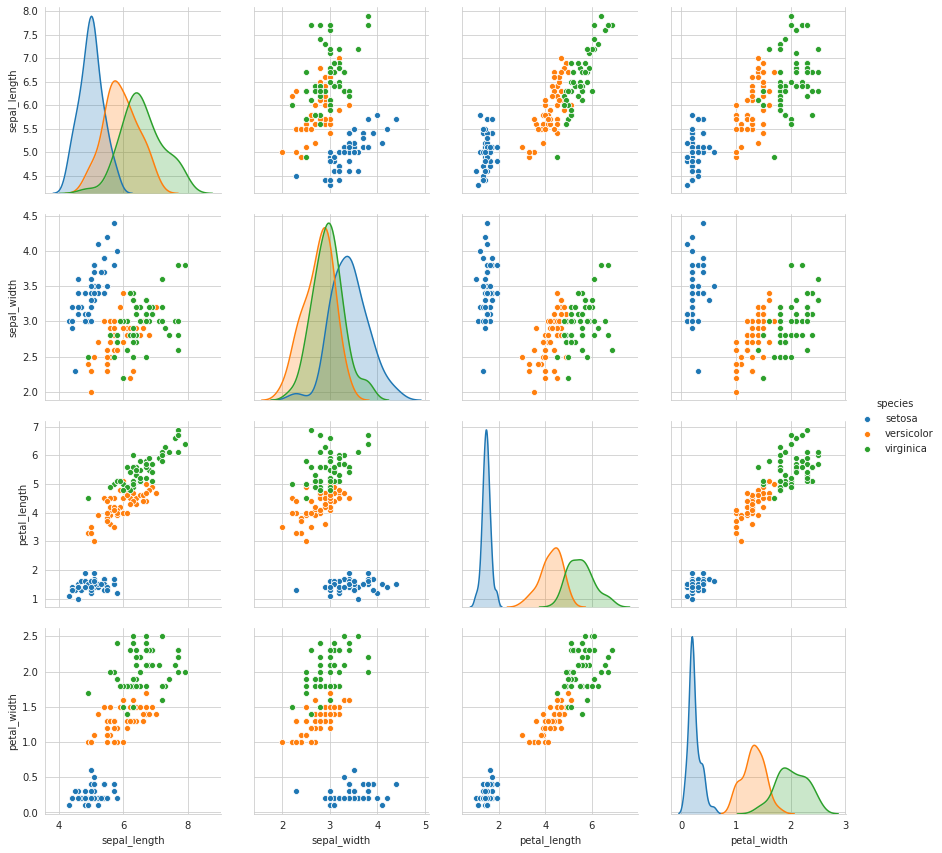

In [2]:
#Load Iris.csv into a pandas dataFrame.
iris_dataset = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

#Pair plots for iris dataset
import seaborn as sns
plt.close();
sns.set_style("whitegrid");
sns.pairplot(iris_dataset, hue="species", size=3);
plt.show()

From the pair plots above, we can see that petal length and petal width are the two most important features that visually separates the three classes of flower most accurately. 

## Bagging.

Bagging stands for **bootstrap aggregation**. The core idea of bagging is to use bootstrapped replicas of the original dataset and use them to train different classifiers. Suppose we are given a dataset, we will create subsets by randomly sampling a bunch of points from the original data, with replacement. Now we will train individual classifiers on each of these bootstrapped subsets. Each of these base classifiers will predict the class label for a given problem. This is where we combine the predictions of all the base models. This part is called the aggregation stage. Typically a simple majority vote is used in a classification system and taking the mean of all predictions for regression models, to combine all the base classifiers into one single model to provide the final output of the ensemble model. 


A simple example of such an approach is the **Random Forest algorithm**. 

- Bagging reduces the high variance of a model while keeping the bias constant, thereby reducing the generalization error. 
- Bagging is a very efficient method especially when you have very limited data. By using bootstrapped samples we are able to get an estimate by aggregating the scores over many samples.  

<tr>
<td> <img src="../images/BaggingFINAL.jpg"> </td>
</tr>

Let us understand the above diagram with the help of a simple example. Let's say we have a training dataset which contains 100K data points. We will create N subsets by randomly sampling 50K data points for each subset. So we have a total of N datasets now. Each of these N datasets will be used to train N different classifiers. At the aggregation stage, all these N predictions will be combined into one single model also called the meta-classifier. Out of the 100K points present originally present in the dataset, if we remove 1000 points, the impact it will have on the sampled datasets will be very less. If you think intuitively, some of these 1000 points might not be present in all the sampled datasets at all and thus the number of points that will be removed from each sampled dataset will be very less. Even zero in some cases! Thus, by using the bootstrap aggregation strategy, the impact of removing 1000 points from the original training set will be very less on the sampled datasets. To sum it up, the impact of removing 1000 such points will be actually less on the base learners, thereby reducing the variance in a model and making it more robust. 

In the code sample below, first, what we do is initialize 8 different base learners. We will fit each of these 8 base learners to our training set and compare it's accuracy to the bagging versions of each of the classifiers. In most of the cases below, we see that there is a slight increase in the model's accuracy when we use the bagging version of each classifier as compared to the normal ones. For simplicity, we will use a 3 fold cross-validation to obtain the accuracy scores across different folds. You can increase the number of folds if you have a large real-world training set. For each of the base learners selected below, we see that bagging actually works! Using bagging has actually improved the accuracy by a certain margin (most notably in the AdaBoostClassifier)

## Encode class variable

In [3]:
from sklearn.preprocessing import LabelEncoder
encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)

##  Define base learners

In [4]:
RANDOM_SEED = 0

#Base Learners
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=RANDOM_SEED)
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
et_clf = ExtraTreesClassifier(n_estimators=5, random_state=RANDOM_SEED)
knn_clf = KNeighborsClassifier(n_neighbors=2)
svc_clf = SVC(C=10000.0, kernel='rbf', random_state=RANDOM_SEED)
rg_clf = RidgeClassifier(alpha=0.1, random_state=RANDOM_SEED)
lr_clf = LogisticRegression(C=20000, penalty='l2', max_iter=1000, random_state=RANDOM_SEED)
adab_clf = AdaBoostClassifier(n_estimators=5,learning_rate=0.001)

## Perform classification with/wthout bagging

In [5]:
classifier_list = [dt_clf, rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, adab_clf]

labels = [clf.__class__.__name__ for clf in classifier_list]

normal_accuracy = []
normal_std = []

bagging_accuracy = []
bagging_std = []

for clf in classifier_list:
    cv_scores = cross_val_score(clf, X, y, cv=3, n_jobs=-1)  # using cross validation; not an unbiased evaluation
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=RANDOM_SEED)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=3, n_jobs=-1)
    
    normal_accuracy.append(np.round(cv_scores.mean(),4))
    normal_std.append(np.round(cv_scores.std(),4))
    
    bagging_accuracy.append(np.round(bagging_scores.mean(),4))
    bagging_std.append(np.round(bagging_scores.std(),4))
    
    print("Accuracy: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), clf.__class__.__name__))
    print("Accuracy: %0.4f (+/- %0.4f) [Bagging %s]\n" % (bagging_scores.mean(), bagging_scores.std(), clf.__class__.__name__))

Accuracy: 0.9333 (+/- 0.0189) [Normal DecisionTreeClassifier]
Accuracy: 0.9533 (+/- 0.0249) [Bagging DecisionTreeClassifier]

Accuracy: 0.9667 (+/- 0.0189) [Normal RandomForestClassifier]
Accuracy: 0.9667 (+/- 0.0189) [Bagging RandomForestClassifier]

Accuracy: 0.9533 (+/- 0.0094) [Normal ExtraTreesClassifier]
Accuracy: 0.9533 (+/- 0.0249) [Bagging ExtraTreesClassifier]

Accuracy: 0.9467 (+/- 0.0094) [Normal KNeighborsClassifier]
Accuracy: 0.9867 (+/- 0.0094) [Bagging KNeighborsClassifier]

Accuracy: 0.9600 (+/- 0.0163) [Normal SVC]
Accuracy: 0.9733 (+/- 0.0189) [Bagging SVC]

Accuracy: 0.7933 (+/- 0.0340) [Normal RidgeClassifier]
Accuracy: 0.8200 (+/- 0.0432) [Bagging RidgeClassifier]

Accuracy: 0.9733 (+/- 0.0189) [Normal LogisticRegression]
Accuracy: 0.9800 (+/- 0.0163) [Bagging LogisticRegression]

Accuracy: 0.6600 (+/- 0.0000) [Normal AdaBoostClassifier]
Accuracy: 0.9600 (+/- 0.0163) [Bagging AdaBoostClassifier]



Here, in the below code sample what we do is visually see how the accuracy improves on using a bagging classifier as compared to a normal one. The black line present at the top of each bar indicates the variance in the model. As we can see, the variance mostly reduces when we use the bagging version of any classifier. However, for some models, we also have a situation where the variance increases slightly more than the normal version of the classifier. This is mostly because of a lack of training data points. Remember we have only 150 observations in our training dataset. Greater the number of data points in our train set, more robust will the final models be. However, from a simple implementation point of view, this code sample helps us understand how to implement the concept of bootstrap aggregation.

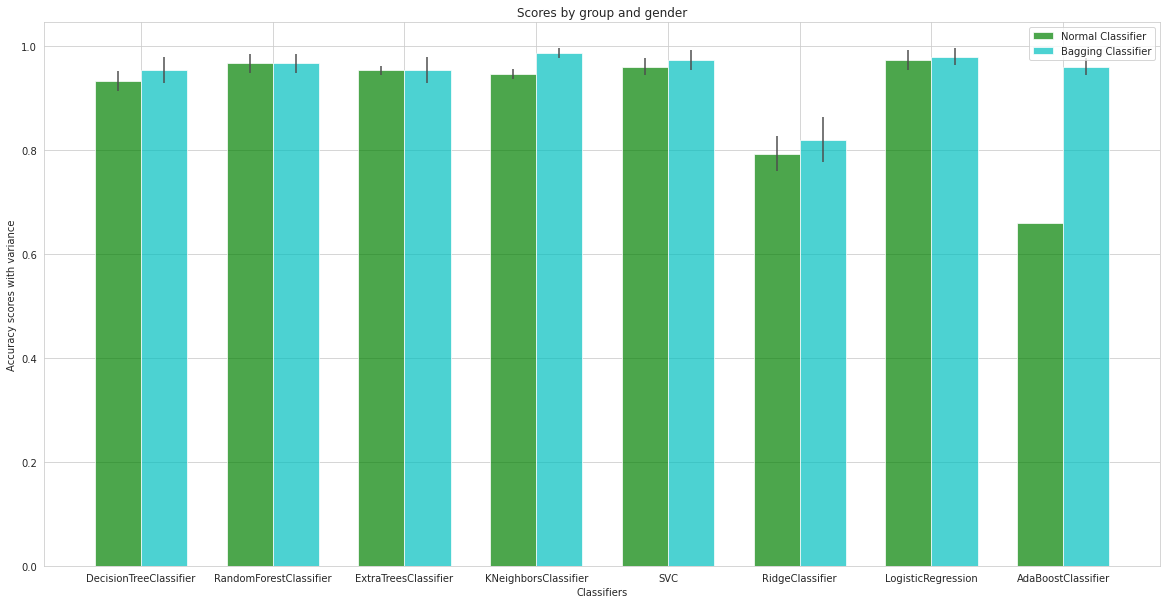

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 8
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

normal_clf = ax.bar(index, normal_accuracy, bar_width, alpha=opacity, color='g', 
                    yerr=normal_std, error_kw=error_config, label='Normal Classifier')
bagging_clf = ax.bar(index + bar_width, bagging_accuracy, bar_width, alpha=opacity, color='c', 
                     yerr=bagging_std, error_kw=error_config, label='Bagging Classifier')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy scores with variance')
ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

#fig.tight_layout()

plt.show()

### Impact of change in bagging accuracies with an increase in the sub-sampling ratio.

A very important factor to be kept in mind while building bagging classifiers is that the accuracy of a model doesn't always increase when we increase the sub-sampling ratio. In the Bagging Classifier library, subsampling, i.e. the fraction of data that gets into each of the base learners, is denoted by the parameter "max_samples". In the code sample below, we will see the display the bagging scores for each of the base learners at various subsampling ratio. We will also plot the bagging scores for each of the base learners in a line chart to get a more intuitive understanding of this concept - that is bagging scores doesn't necessarily increase when we increase the sub-sampling ratio.

In [17]:
### Display the accuracy of different bagging classifiers at various sub sampling ratio in a Pretty table.

subsampling_ratio = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

various_bagging_scores = []

for clf in classifier_list:
    cv_scores = cross_val_score(clf, X, y, cv=3, n_jobs=-1)
#     print("\nAccuracy: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), clf.__class__.__name__))
    print(f"==> {clf.__class__.__name__}")
    mean_bagging_score = []
    for ratio in subsampling_ratio:
        bagging_clf = BaggingClassifier(clf, max_samples=ratio, max_features=3, random_state=RANDOM_SEED)
        bagging_scores = cross_val_score(bagging_clf, X, y, cv=3, n_jobs=-1)
        mean_bagging_score.append(bagging_scores.mean())
        #print("Bagging accuracy: %0.4f [max_samples %0.2f]" % (bagging_scores.mean(), ratio))
    various_bagging_scores.append(mean_bagging_score)

# various_bagging_scores.insert(0,subsampling_ratio)

==> DecisionTreeClassifier
==> RandomForestClassifier
==> ExtraTreesClassifier
==> KNeighborsClassifier
==> SVC
==> RidgeClassifier
==> LogisticRegression
==> AdaBoostClassifier


In [18]:
table = np.around(pd.DataFrame(various_bagging_scores, 
                               columns = subsampling_ratio, index=classifier_list), 2)
table

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
"DecisionTreeClassifier(max_depth=2, random_state=0)",0.94,0.94,0.96,0.95,0.95,0.95,0.95,0.95,0.95,0.94
"RandomForestClassifier(n_estimators=10, random_state=0)",0.95,0.95,0.96,0.97,0.96,0.96,0.97,0.97,0.96,0.96
"ExtraTreesClassifier(n_estimators=5, random_state=0)",0.95,0.97,0.97,0.95,0.95,0.95,0.95,0.95,0.95,0.95
KNeighborsClassifier(n_neighbors=2),0.97,0.97,0.98,0.99,0.97,0.97,0.97,0.97,0.97,0.96
"SVC(C=10000.0, random_state=0)",0.97,0.97,0.97,0.97,0.97,0.96,0.98,0.99,0.97,0.97
"RidgeClassifier(alpha=0.1, random_state=0)",0.83,0.79,0.83,0.82,0.83,0.83,0.83,0.83,0.83,0.82
"LogisticRegression(C=20000, max_iter=1000, random_state=0)",0.96,0.97,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.97
"AdaBoostClassifier(learning_rate=0.001, n_estimators=5)",0.93,0.95,0.95,0.96,0.95,0.95,0.87,0.97,0.96,0.96


This code sample helps us understand that the bagging accuracy doesn't always increase when we increase the sub-sampling ratio. As we can clearly see for Ada Boost classifier (denoted by the maroon line), that the bagging accuracy drops to a significantly lower value when we increase the sampling ration from 0.7 to 0.8. For the Decision Tree classifier, the bagging accuracy falls beyond the sampling ratio of 0.4. This behavior is almost the same for all the different base learners. There is absolutely no evidence of the fact that a higher sub-sampling ratio means a higher bagging accuracy. I have taken my sampling ratio to be 0.4. You can try and experiment with different values on a different dataset and see if you find any correlation between the sub-sampling ratio and the bagging accuracy.

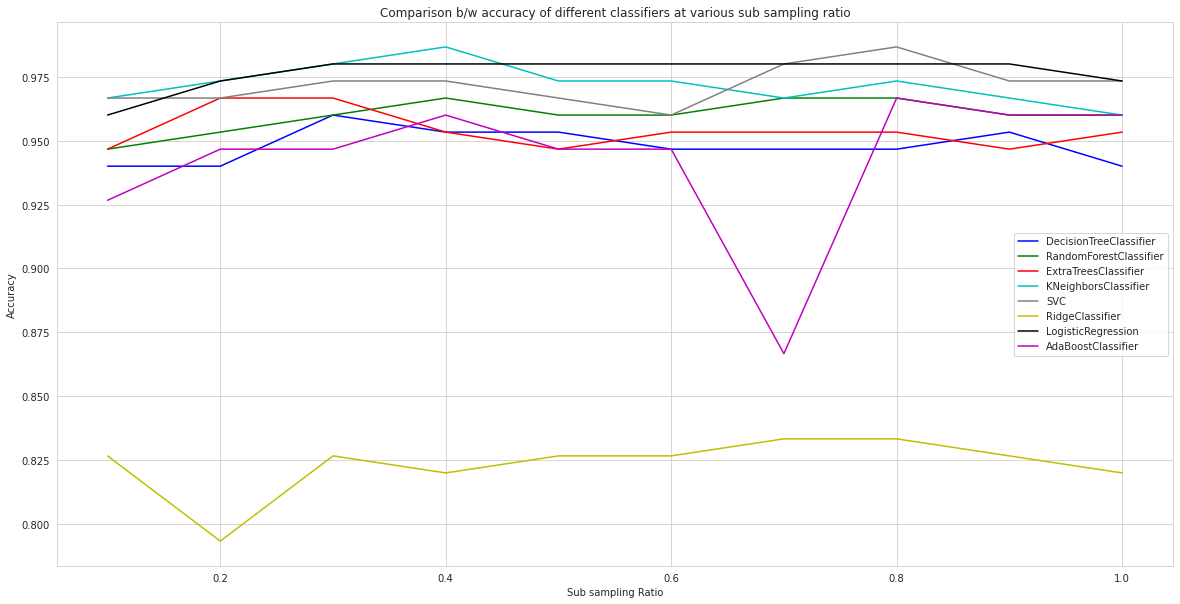

In [19]:
#Plot the bagging scores using a line chart.

# various_bagging_scores.remove(various_bagging_scores[0])

x_axes = subsampling_ratio

color_map = ['blue','g','r','c','grey','y','black','m']
plt.figure(figsize=(20,10))
for index in range(0,len(labels)):
    plt.plot(x_axes, various_bagging_scores[index], color=color_map[index], label=labels[index])
plt.xlabel('Sub sampling Ratio')
plt.ylabel('Accuracy')
plt.title("Comparison b/w accuracy of different classifiers at various sub sampling ratio")
plt.legend()
plt.show()

# References

[1] S. Paual. [Ensemble Learning — Bagging, Boosting, Stacking and Cascading Classifiers in Machine Learning using SKLEARN and MLEXTEND libraries](https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674) 